In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E

In [2]:
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)

<IPython.core.display.Javascript object>


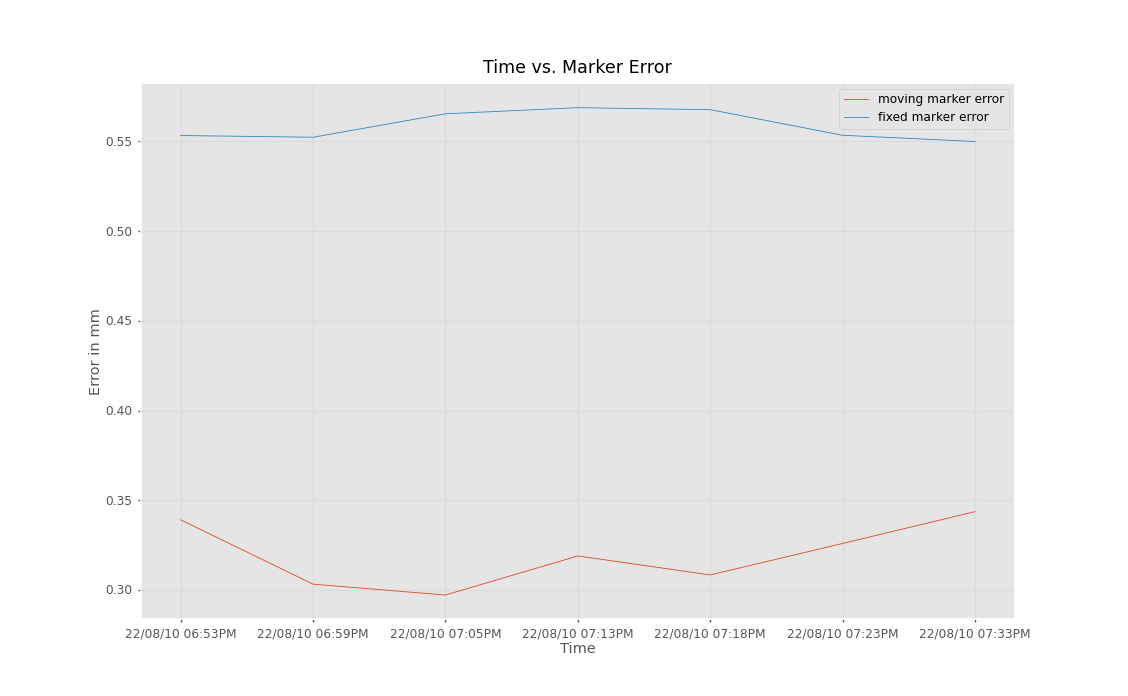

In [4]:
Me_list = []
Fe_list = []
TT_list = []
for x in data_load:
        Me_list.append(data_load[x][0].error)
        Fe_list.append(data_load[x][1].error)
        TT_list.append(data_load[x][0].time)
plt.plot(TT_list,Me_list)
plt.plot(TT_list,Fe_list)
plt.ylabel('Error in mm')
plt.xlabel('Time')
plt.legend(["moving marker error","fixed marker error"])
plt.title("Time vs. Marker Error")
plt.show()

In [ ]:
Tm = SE3(data_load['scan0'][0].T)
Tfix = SE3(data_load['scan0'][1].T)
SE3().plot(frame='0', color='black')
Tm.plot(frame='1')

In [ ]:
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Ry(90, 'deg')*E.Rz(-90, 'deg')
Tfixi = Tfix.inv()
Tfk = SE3(e.eval([1]))
Tfk2 = Tfixi*Tfk
SE3().plot(frame='0', color='black')
Tm.plot(frame='1',color='blue')
Tfk2.plot(frame='2',color='red')

In [5]:
offset = data_load['scan0'][2].joint_postion

<IPython.core.display.Javascript object>


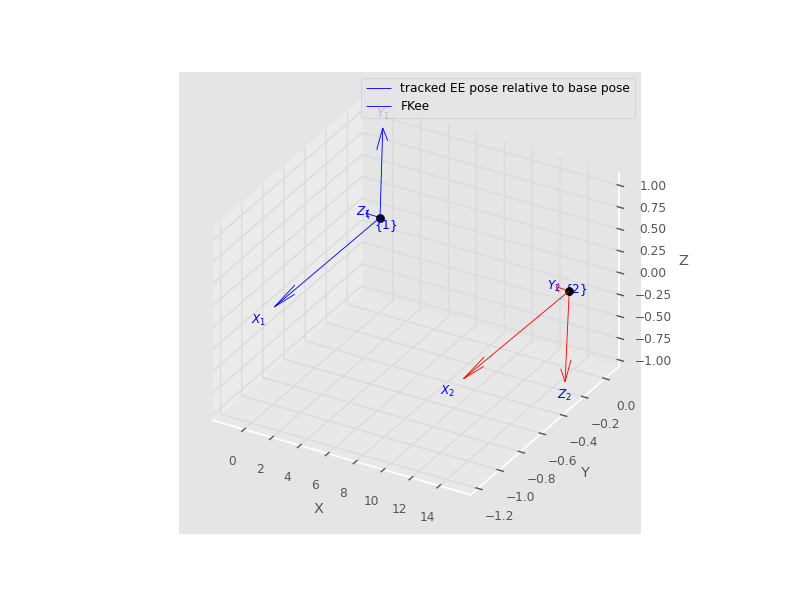

In [6]:
Tbase = SE3(data_load['scan1'][1].T)
Tee = SE3(data_load['scan1'][0].T)
Tfinal = Tbase.inv()*Tee
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Ry(90, 'deg')*E.Rz(-90, 'deg')
Tfk = Tbase.inv()*SE3(e.eval([data_load['scan1'][2].joint_postion]))
Tfinal.plot(frame='1',color='blue')
Tfk.plot(frame='2',color='red')
plt.legend(["tracked EE pose relative to base pose","FKee"])

In [14]:
marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ marker.T + tracked_t).T
error = permuted_centroids-transformed_marker

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=22
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 130.51it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.90802835 0.05904166]
Everything looks good!
the final error is:  0.05904166390883367


In [15]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
visualization_list1 = copy.deepcopy(visualization_list2)
o3d.visualization.draw_geometries(visualization_list2)

Error (mm): [[ 0.04 -0.02  0.02]
 [-0.06 -0.03 -0.01]
 [ 0.06  0.03 -0.03]
 [-0.04  0.03  0.02]]
Error norm (mm): 0.3436325476692616
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
marker_3d_fk = create_marker_visualization(marker, [0.2, 0.2, 0.8], Tfk.R, Tfk.t.reshape((3,1)))
marker_3d_fk.append(create_coordinate_frame_visualization(Tfk.R, Tfk.t.reshape((3,1))))
marker_3d_b = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_b.append(create_coordinate_frame_visualization(Tfinal.R, Tfinal.t.reshape((3,1))))
visualization_list3 = marker_3d_b+marker_3d_fk + [marker_mesh]

In [16]:
o3d.visualization.draw_geometries(visualization_list2+visualization_list3)